In [1]:
# import numpy as np
# import re

# ptrn = (r'BLOCK: offset: (?P<offset>\d+) len: (?P<len>\d+) phased: (?P<phased>\d+) ' +
#                  r'SPAN: (?P<span>\d+) fragments (?P<fragments>\d+)')

# def parse_hap_file(fn):
#     with open(fn) as f:
#         for l in f:
#             if l.startswith('BLOCK'):
#                 g = re.match(ptrn, l)
#                 yield g.group('len')

# ema_blocks = np.fromiter(parse_hap_file('EMA_100pc-downsample-strelka2.hap'), int)
# bwa_blocks = np.fromiter(parse_hap_file('TruSeq_100pc-downsample-strelka2.hap'), int)


In [104]:
from cyvcf2 import VCF
from collections import defaultdict

def parse_vcf_file(fn):
    blocks = []
    
    current_ps = None
    for rec in VCF(fn):
        ps = None
        if 'PS' in rec.FORMAT:
            ps = rec.format('PS', int)[0][0]
        #print(ps, current_ps, ps == current_ps)
        if ps is not None and current_ps is not None and ps == current_ps:
            blocks[-1] += 1
        else:
            blocks.append(1)
            current_ps = ps
    return sorted(blocks, reverse=True)

ema_blocks = parse_vcf_file('examples/keygenes_EMA_shared_with_bwa.vcf/0000.vcf')
bwa_blocks = parse_vcf_file('examples/keygenes_BWA_shared_with_ema.vcf/0000.vcf')

def parse_by_gene(fn):
    ps_by_gene = defaultdict(set)
    vars_by_gene = defaultdict(int)
    
#     current_ps = None
    for rec in VCF(fn):
        ps = None
        if 'ANN' in dict(rec.INFO):
            anns = rec.INFO['ANN'].split(',')
            genes_effected = set()
            for ann in anns:
                #C|upstream_gene_variant|MODIFIER|RNU6-291P|ENSG00000207451|transcript|ENST00000384720|snRNA||n.-831_-830delTT|||||831|,C
                _, _, impact, gene, _, _, _, region_type = ann.split('|')[:8]
                if impact in ['HIGH', 'MODERATE']:  
                    vars_by_gene[gene] += 1
                    ps = rec.format('PS', int)[0][0] if 'PS' in rec.FORMAT else rec.POS
                    ps_by_gene[gene].add(ps)
                    break
    
    return ps_by_gene, vars_by_gene
    
ema_ps_by_gene, ema_vars_by_gene = parse_by_gene('examples/keygenes_EMA_shared_with_bwa.vcf/0000.vcf')
bwa_ps_by_gene, bwa_vars_by_gene = parse_by_gene('examples/keygenes_BWA_shared_with_ema.vcf/0000.vcf')


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

total genes: 98 | phased blocks distribution: [37, 15, 9, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
total genes: 98 | phased blocks distribution: [38, 15, 9, 8, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


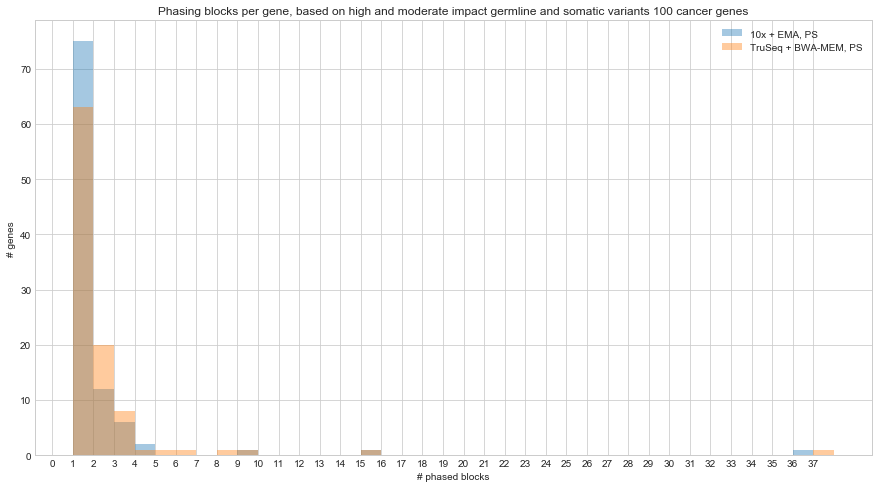

In [128]:
plt.figure(figsize=(15, 8))

ticks_num = 0
for ps_by_gene, l in [(ema_ps_by_gene, "10x + EMA, PS"), (bwa_ps_by_gene, "TruSeq + BWA-MEM, PS")]:
    x = sorted((len(ps) for ps in ps_by_gene.values()), reverse=True)
    ticks_num = max(ticks_num, x[0])
    print('total genes:', len(x), '| phased blocks distribution:', x)
    ax = sns.distplot(x, label=l, kde=False, bins=x[0] - 1)

plt.xticks(np.arange(ticks_num))
plt.xlabel('# phased blocks')
plt.ylabel('# genes')
plt.title('Phasing blocks per gene, based on high and moderate impact germline and somatic variants 100 cancer genes')
plt.legend()
pass

total genes: 98 | distribution: [38, 15, 11, 9, 7, 6, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
total genes: 98 | distribution: [38, 15, 11, 9, 7, 6, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


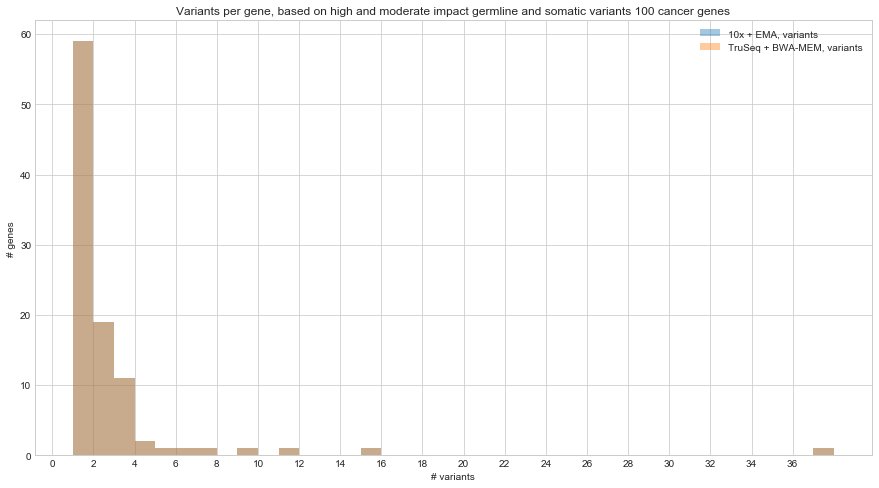

In [127]:
plt.figure(figsize=(15,8))

ticks_num = 0
for vars_by_gene, l in [(ema_vars_by_gene, "10x + EMA, variants"), (bwa_vars_by_gene, "TruSeq + BWA-MEM, variants")]:
    x = sorted((vars for vars in vars_by_gene.values()), reverse=True)
    ticks_num = max(ticks_num, x[0])
    print('total genes:', len(x), '| distribution:', x)
    ax = sns.distplot(x, label=l, kde=False, bins=x[0]-1)

plt.xticks(np.arange(ticks_num, step=2))
plt.xlabel('# variants')
plt.ylabel('# genes')
plt.title('Variants per gene, based on high and moderate impact germline and somatic variants 100 cancer genes')
plt.legend()
pass

/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


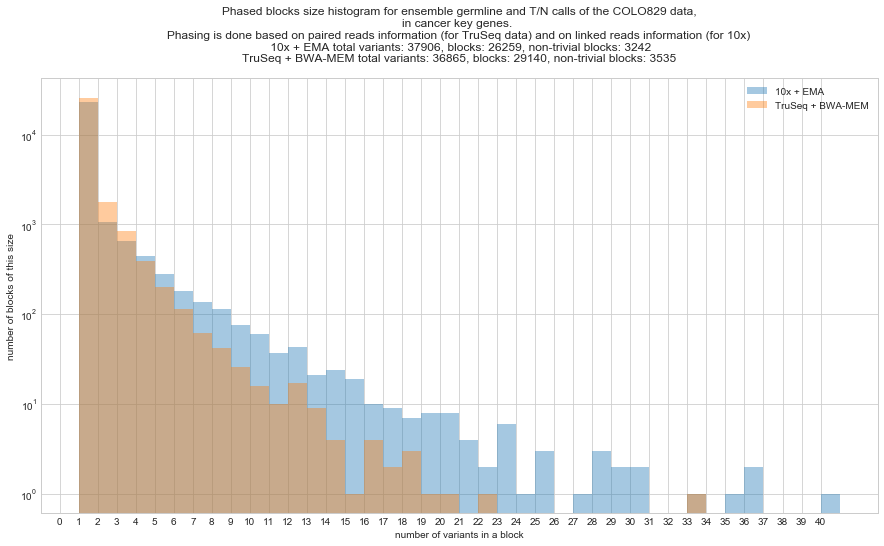

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

plt.figure(figsize=(15,8))
plt.yscale('log')

bin_num = max(ema_blocks[0], bwa_blocks[0])
plt.xticks(np.arange(bin_num))

for x, l in [(ema_blocks, "10x + EMA"), (bwa_blocks, "TruSeq + BWA-MEM")]:
    ax = sns.distplot(x, label=l, kde=False, bins=x[0]-1)
#     ax = plt.hist(x, label=l, bins=x[0]+1)
#     ax.set_xticks(np.arange(0, bins, step=1))


plt.xlabel('number of variants in a block')
plt.ylabel('number of blocks of this size')
plt.title(f'Phased blocks size histogram for ensemble germline and T/N calls of the COLO829 data,\n'
          f'in cancer key genes. \n'
          f'Phasing is done based on paired reads information (for TruSeq data) and on linked reads '
          f'information (for 10x)\n '
          f'10x + EMA total variants: {sum(ema_blocks)}, blocks: {len(ema_blocks)}, '
          f'non-trivial blocks: {len([b for b in ema_blocks if b != 1])}\n'
          f'TruSeq + BWA-MEM total variants: {sum(bwa_blocks)}, blocks: {len(bwa_blocks)}, '
          f'non-trivial blocks: {len([b for b in bwa_blocks if b != 1])}\n'
          )
plt.legend()
pass


/Users/vsaveliev/miniconda3/envs/umccrise/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


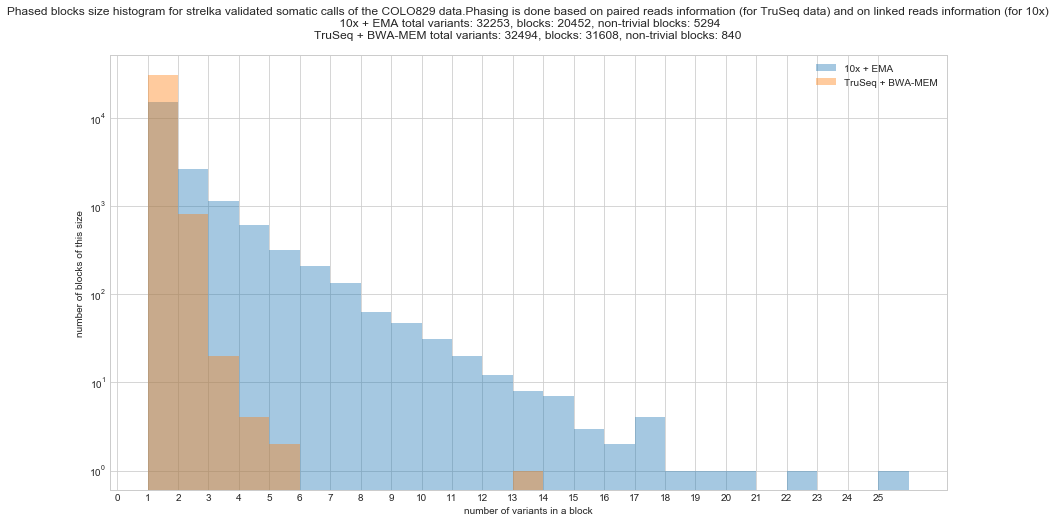

In [62]:
ema_blocks = parse_vcf_file('examples/somatic_EMA_100pc.phased.vcf')
bwa_blocks = parse_vcf_file('examples/somatic_BWA_100pc.phased.vcf')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

plt.figure(figsize=(15,8))
plt.yscale('log')

bin_num = max(ema_blocks[0], bwa_blocks[0])
plt.xticks(np.arange(bin_num))

for x, l in [(ema_blocks, "10x + EMA"), (bwa_blocks, "TruSeq + BWA-MEM")]:
    ax = sns.distplot(x, label=l, kde=False, bins=x[0]-1)

plt.xlabel('number of variants in a block')
plt.ylabel('number of blocks of this size')
plt.title(f'Phased blocks size histogram for strelka validated somatic calls of the COLO829 data.'
          f'Phasing is done based on paired reads information (for TruSeq data) and on linked reads '
          f'information (for 10x)\n '
          f'10x + EMA total variants: {sum(ema_blocks)}, blocks: {len(ema_blocks)}, '
          f'non-trivial blocks: {len([b for b in ema_blocks if b != 1])}\n'
          f'TruSeq + BWA-MEM total variants: {sum(bwa_blocks)}, blocks: {len(bwa_blocks)}, '
          f'non-trivial blocks: {len([b for b in bwa_blocks if b != 1])}\n'
          )
plt.legend()
pass
